## Setup

### Install Packages

In [217]:
import numpy as np
from numpy import random
import gpflow
from numpy.core.numeric import indices, zeros_like
import tensorflow as tf
import matplotlib.pyplot as plt
import time  # for timing how long it takes for the program to run
import itertools
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from gpflow.ci_utils import ci_niter

# rng = random.default_rng(2022)  # random number generator from seed
rng = np.random.RandomState(123)
tf.random.set_seed(42)

### Set up data

Number of inputs: 1600


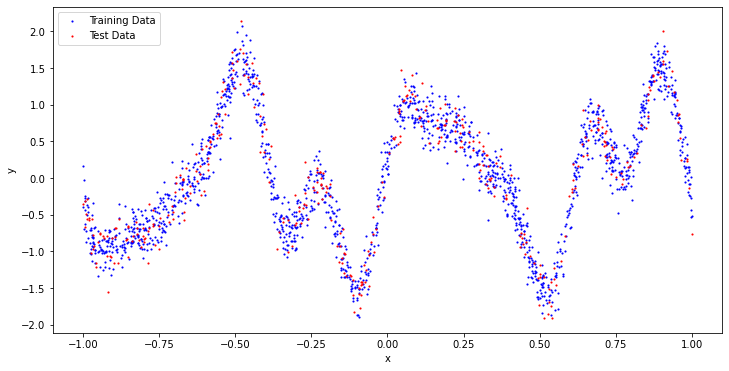

In [218]:

# Import data (Snelson 1D)
# X = np.genfromtxt("data/train_inputs.txt").reshape(-1, 1)
# Y = np.genfromtxt("data/train_outputs.txt").reshape(-1, 1)

def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)


N_tot = 2000  # Number of total input points (training and test)

X = rng.rand(N_tot, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N_tot, 1)  # Noisy Y values

test_set_proportion = 0.2



# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=test_set_proportion,
    random_state=88,
    shuffle=True
    )

N = len(X_train)

print("Number of training inputs:", N)

plt.figure(figsize=(12,6))
plt.scatter(X_train,Y_train, marker=".", color="b", s=5, label="Training Data")
plt.scatter(X_test,Y_test, marker=".", color="r", s=5, label="Test Data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Loss function for model validation

Using the negative log validation density loss for cross validation:


$$\log p\left(\mathbf{y}_{\ast} \mid X, \mathbf{y}, \boldsymbol{\theta}\right)= \sum \limits _{i=1} ^{N_\ast} -\frac{1}{2} \log \sigma_{\ast i}^{2}-\frac{\left(y_{\ast i}-\mu_{i}\right)^{2}}{2 \sigma_{\ast i}^{2}}-\frac{1}{2} \log 2 \pi$$


In [219]:
def LPD_fn(Y_predict_mu, Y_predict_var, Y_test):
    """
        Loss function - negative log validation density loss.

    Args:
        - X_train: Input values for training dataset
        - Y_train: Output values for training dataset
        - X_test: Input values for test dataset

    Returns:
        - Y_predict_mu: Predicted output values for inputs X_test
        - Y_predict_var: The variances for Y_predict_mu

    
    """

    term_1 = np.log(Y_predict_var)
    term_2 = ((Y_predict_mu - Y_test)**2)/(Y_predict_var)
    term_3 = np.log(2*np.pi)
    return np.sum(-0.5*(term_1+term_2+term_3))

def MSE(Y_predict_mu, Y_predict_var, Y_test):
    return np.mean((Y_predict_mu - Y_test)**2)

In [220]:
def resort_data(X_test, Y_test, SGPR_y_predict, SGPR_var):

    X_test, SGPR_y_predict, SGPR_var, Y_test= zip(*sorted(zip(X_test, SGPR_y_predict, SGPR_var, Y_test)))

    X_test = np.array(X_test)
    SGPR_y_predict = np.array(SGPR_y_predict)
    Y_test = np.array(Y_test)
    SGPR_var = np.array(SGPR_var)

    return X_test, Y_test, SGPR_y_predict, SGPR_var

### Defining plots for GPs

In [221]:
def plot(model, title="", plot_inducing_points=False):
    pY, pYv = model.predict_y(X_test)  # Predict Y values at test locations
    X_t, Y_t, prY, prYv = resort_data(X_test, Y_test, pY, pYv)
    plt.figure(figsize=(12, 4))
    plt.title(title)    
    plt.plot(X_train, Y_train, "x", label="Training points", alpha=0.2)
    plt.scatter(X_t, Y_t, marker="x", color="r", label="Test points")
    (line,) = plt.plot(X_t, prY, lw=1.5, label="Mean of predictive posterior")
    col = line.get_color()
    plt.fill_between(
        X_t[:, 0],
        (prY - 2 * prYv ** 0.5)[:, 0],
        (prY + 2 * prYv ** 0.5)[:, 0],
        color=col,
        alpha=0.6,
        lw=1.5,
    )
    if plot_inducing_points == True:
        Z = model.inducing_variable.Z.numpy()
        plt.plot(Z, np.zeros_like(Z), "k|", mew=2, label="Inducing locations")
    plt.legend(loc="lower right")

    return pY, pYv

## 1D Classic GP Regression

In [222]:
kernel_GPR = gpflow.kernels.SquaredExponential()

m_GPR = gpflow.models.GPR(
    data=(X_train, Y_train),
    kernel=kernel_GPR,
    mean_function=None
    )

In [223]:
opt_GPR = gpflow.optimizers.Scipy()

log_GPR = opt_GPR.minimize(
    m_GPR.training_loss,
    m_GPR.trainable_variables,
    options=dict(maxiter=100)
    )



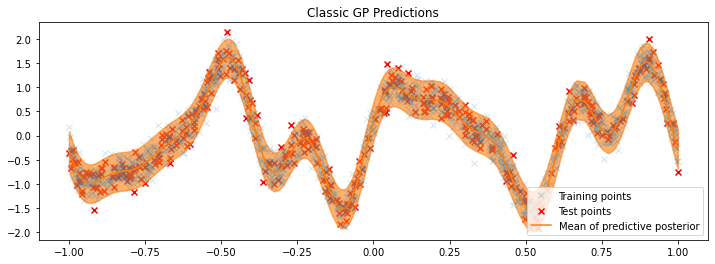

In [224]:
GPR_y_predict, GPR_var = plot(model=m_GPR, title="Classic GP Predictions", plot_inducing_points=False)

## Sparse Gaussian Process Regression (SGPR) - Titsias 2009 method

In [236]:
# Number of inducing inputs:
M = 50

Z_SGPR = X_train[:M, :].copy()

kernel_SGPR = gpflow.kernels.SquaredExponential()

m_SGPR = gpflow.models.SGPR(
    data=(X_train, Y_train),
    inducing_variable=Z_SGPR,
    kernel=kernel_SGPR
    )
    

In [237]:
opt_SGPR = gpflow.optimizers.Scipy()

log_SGPR = []

for i in range(20):
    log = opt_SGPR.minimize(
        m_SGPR.training_loss,
        m_SGPR.trainable_variables,
        options=dict(maxiter=1)
        )
    log_SGPR.append(m_SGPR.elbo())

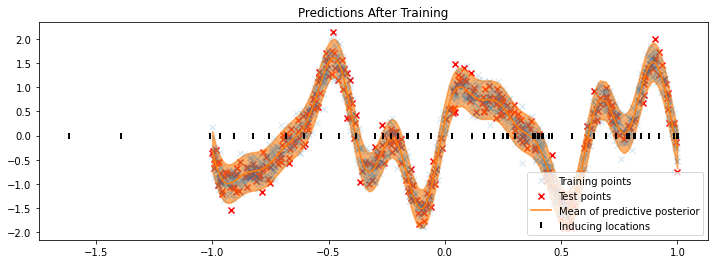

In [238]:
SGPR_y_predict, SGPR_var = plot(model=m_SGPR, title="Predictions After Training", plot_inducing_points=True)

## Sparse Variational Gaussian Process (SVGP) - Hensman 2013 Method

In [239]:
M = 50  # Number of inducing locations

Z_SVGP = X_train[:M, :].copy()

kernel = gpflow.kernels.SquaredExponential()

m_SVGP = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z_SVGP, num_data=N)


In [240]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(N)

In [241]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.set_trainable(m_SVGP.inducing_variable, False)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

maxiter = ci_niter(20000)

SVGP_logf = run_adam(m_SVGP, maxiter)

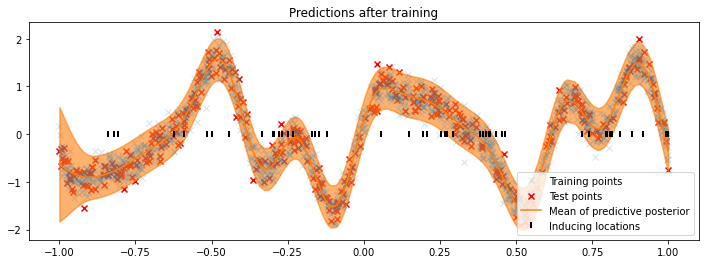

In [242]:
SVGP_y_predict, SVGP_var = plot(m_SVGP, "Predictions after training", plot_inducing_points=True)

## Comparing the models

### How good are the predictions?

Here we have used two different metrics to determine how well the three different methods perform on the test set predictions:

- log predictive density (the higher the value, the more accurate the predictions)
- mean squared error (the lower the value, the better the predictions) 

We can see here that the SGPR method performs better than SVGP on both metrics (higher LPD and lower MSE).

In [243]:
# Classic GPR test error
GPR_CV_error = LPD_fn(GPR_y_predict, GPR_var, Y_test)
GPR_MSE = MSE(GPR_y_predict, GPR_var, Y_test)

print("GPR Log Predictive Density error:", GPR_CV_error)
print("GPR Mean Squared Error:", GPR_MSE)

# SGPR (Titsias 2009) test error
SGPR_error = LPD_fn(SGPR_y_predict, SGPR_var, Y_test)
SGPR_MSE = MSE(SGPR_y_predict, SGPR_var, Y_test)

print("SGPR Log Predictive Density error:", SGPR_error)
print("SGPR Mean Squared Error:", SGPR_MSE)

# SVGP (Hensman 2013) test error
SVGP_error = LPD_fn(SVGP_y_predict, SVGP_var, Y_test)
SVGP_MSE = MSE(SVGP_y_predict, SVGP_var, Y_test)

print("SVGP Log Predictive Density error:", SVGP_error)
print("SVGP Mean Squared Error:", SVGP_MSE)


GPR Log Predictive Density error: 77.76915184663588
GPR Mean Squared Error: 0.039698263449603775
SGPR Log Predictive Density error: 77.8103619906804
SGPR Mean Squared Error: 0.039689094114016964
SVGP Log Predictive Density error: 62.43739845115958
SVGP Mean Squared Error: 0.04111430838240649


### How quickly do the models converge?

The SGPR method converges to the approximation much faster than SVGP during the optimisation process with respect to each iteration. Furthermore, because of the use of stochastic gradient descent, this results in a very volatile variation of the ELBO with each iteration - surely it's possible that the optimisation could stop at an iteration where the ELBO is at a low point? In which case, a poor approximation to the posterior is made.

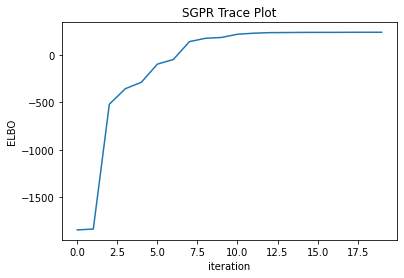

In [245]:
plt.plot(np.arange(20)[::1], log_SGPR)
plt.xlabel("iteration")
plt.title("SGPR Trace Plot")
_ = plt.ylabel("ELBO")

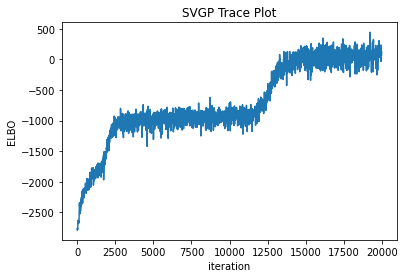

In [ ]:
plt.plot(np.arange(maxiter)[::10], SVGP_logf)
plt.xlabel("iteration")
plt.title("SVGP Trace Plot")
_ = plt.ylabel("ELBO")
print()

### How good are the approximations?
A good measure of how similar the approximations to the true posterior, made by SGPR and SVGP methods, to the true posterior calculated in classic GPR is given by the KL divergence between the two distributions. This is given by

$$K L(q(f) \| p(f \mid y))=-E L B O+\log (p(y))$$

where $\log (p(y))$ is the log marginal likelihood.

We can see that the SGPR method (Titsias) appears to approximate the posterior better than the SVGP method:

In [362]:
KL_SGPR = m_GPR.log_marginal_likelihood() - m_SGPR.elbo()
KL_SVGP = m_GPR.log_marginal_likelihood() - m_SVGP.elbo((X_train, Y_train))
print("Log marginal likelihood (from classic GPR) is ", m_GPR.log_marginal_likelihood())
print("KL divergence of SGPR posterior with true posterior:", float(KL_SGPR))
print("KL divergence of SVGP posterior with true posterior:", float(KL_SVGP))

tf.Tensor(241.51783990342392, shape=(), dtype=float64)
KL divergence of SGPR posterior with true posterior: 0.2545449248291334
KL divergence of SVGP posterior with true posterior: 186.76003834894647


How do we get a log marginal likelihood that is greater than 0, since we are taking log of a probability?

## Investigation into inducing points

### Set up a loop that carries out SGPR for different number of inducing points

In [304]:
inducing_point_proportions = np.logspace(-2, 0, 10)

M = N*inducing_point_proportions

M = [int(x) for x in M]

times = []

logs_SGPR = []

for m in M:

    Z_SGPR = X_train[:m, :].copy()


    kernel_SGPR = gpflow.kernels.SquaredExponential()

    m_SGPR = gpflow.models.SGPR(
        data=(X_train, Y_train),
        inducing_variable=Z_SGPR,
        kernel=kernel_SGPR
        )
    
    opt_SGPR = gpflow.optimizers.Scipy()

    log_SGPR = []

    start_time = time.time()

    for i in range(20):
        log = opt_SGPR.minimize(
            m_SGPR.training_loss,
            m_SGPR.trainable_variables,
            options=dict(maxiter=1)
            )
        log_SGPR.append(m_SGPR.elbo())

    times.append(time.time()-start_time)

    logs_SGPR.append(log_SGPR)

### Time taken to carry out SGPR

As we can see below, the time for the computation remains low (< 12 seconds) for a ratio of number of inducing points to number of training points up to 0.129 (M = 206).

[0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]
[16, 26, 44, 74, 123, 206, 344, 575, 959, 1600]


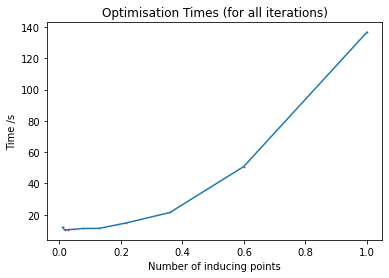

In [361]:
print(inducing_point_proportions)
print(M)
# print(times)
plt.plot(inducing_point_proportions, times)
plt.scatter(inducing_point_proportions, times, s=0.5, c="r")
plt.xlabel("Number of inducing points")
plt.title("Optimisation Times (for all iterations)")
_ = plt.ylabel("Time /s")

### Quality of approximations

Below, trace plots for different numbers of inducing points have been made. We can see that not only the optimisation converges faster with each iteration for larger M, but we also get a better final approximation (larger ELBO).

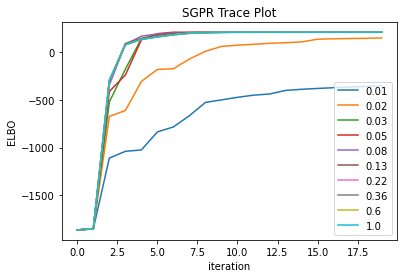

In [322]:
for i in range(len(M)):
    plt.plot(np.arange(20), logs_SGPR[i], label=round(inducing_point_proportions[i], 2))
    plt.xlabel("iteration")
    plt.title("SGPR Trace Plot")
    _ = plt.ylabel("ELBO")
    plt.legend()

Below is the plot for the final ELBO with the number of inducing points. There is no visible improvement to the final ELBO after an inducint point proportion of 0.028 (M = 44)

[-353.19690622  148.93196591  208.67628556  208.74145692  208.71023176
  208.66700481  208.6116105   208.61952853  208.62081121  208.6212682 ]
[16, 26, 44, 74, 123, 206, 344, 575, 959, 1600]


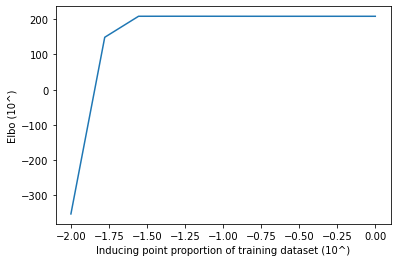

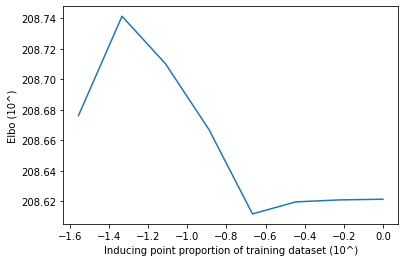

In [360]:
print(np.array(logs_SGPR)[:,-1])


plt.figure()
plt.plot(np.log10(inducing_point_proportions), np.array(logs_SGPR)[:,-1])
plt.xlabel("Inducing point proportion of training dataset (10^)")
plt.ylabel("Elbo (10^)")
plt.show()

plt.figure()
plt.plot(np.log10(inducing_point_proportions)[2:], np.array(logs_SGPR)[2:,-1])
plt.xlabel("Inducing point proportion of training dataset (10^)")
plt.ylabel("Elbo")
plt.show()
